In [1]:
import andi
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from andi_funcs import package_tracks
from tensorflow.keras.models import load_model

%matplotlib notebook
np.random.seed(2) 

## Segmentation of trajectories using trained CNNs

This notebook demonstrates how to use the trained CNN models in this package to perform segmentation on trajectories with switching modes of diffusion. This is demonstrated here with simulated (1D) data.

First we need to load the relevant model for 1D tracks. There is a separate model for 2D tracks.

#### Load model

In [2]:
model = load_model('../Task3_Segmentation/Models/1D.h5');

2023-01-18 09:22:46.182632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Generate data

Generate data using the andi_datasets package. This will simulate a series of trajectories of length 200, each one containing one swich between two different modes of diffusion. The position of the changepoint is drawn randomly from a uniform distribution in the range [1, 200].

In [3]:
AD = andi.andi_datasets()
X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N=100, tasks=[3], dimensions=[1])

positions_truth = np.array(Y3[0])[:, 1].astype(int)  # switchpoint info in column 1
tracks = X3[0]

Creating a dataset for task(s) [3] and dimension(s) [1].
Generating dataset for dimension 1.


/Users/blandt/anaconda3/anaconda3/envs/andi_challenge/lib/python3.7/site-packages/fbm/fbm.py:172: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  "Combination of increments n and Hurst value H "


#### Preprocess/package tracks

Preprocessing and packaging the tracks for input into the CNN. See [here](trajectory_preprocessing.ipynb) for details.

In [4]:
cnn_input = package_tracks(tracks=tracks, max_T=200, dimensions=1)

#### Perform predictions

The CNN model takes the cnn_input and outputs an array of 199 numbers for each trajectory, representing a probability for a switch point at each step in the trajectory. As there is precisely one changepoint in all of the trajectories in this challenge, a softmax is applied to the output so that all values add to one. Of course this won't be suitable for tracks in which there are >1 changepoint, nor is it designed for identifying the absence of a changepoint in tracks with a single diffusion model. These are clear limitations of method, especially when it comes to analysing real data in which the number of switch points in a trajectory is unknown, and should be addressed in future attempts to build upon and improve these methods.

In [5]:
cnn_output = model.predict(cnn_input)

4/4 [==============================] - 1s 51ms/step


In [6]:
print(cnn_output.shape)

(100, 199)


The full output is shown below for a single trajectory:

<IPython.core.display.Javascript object>


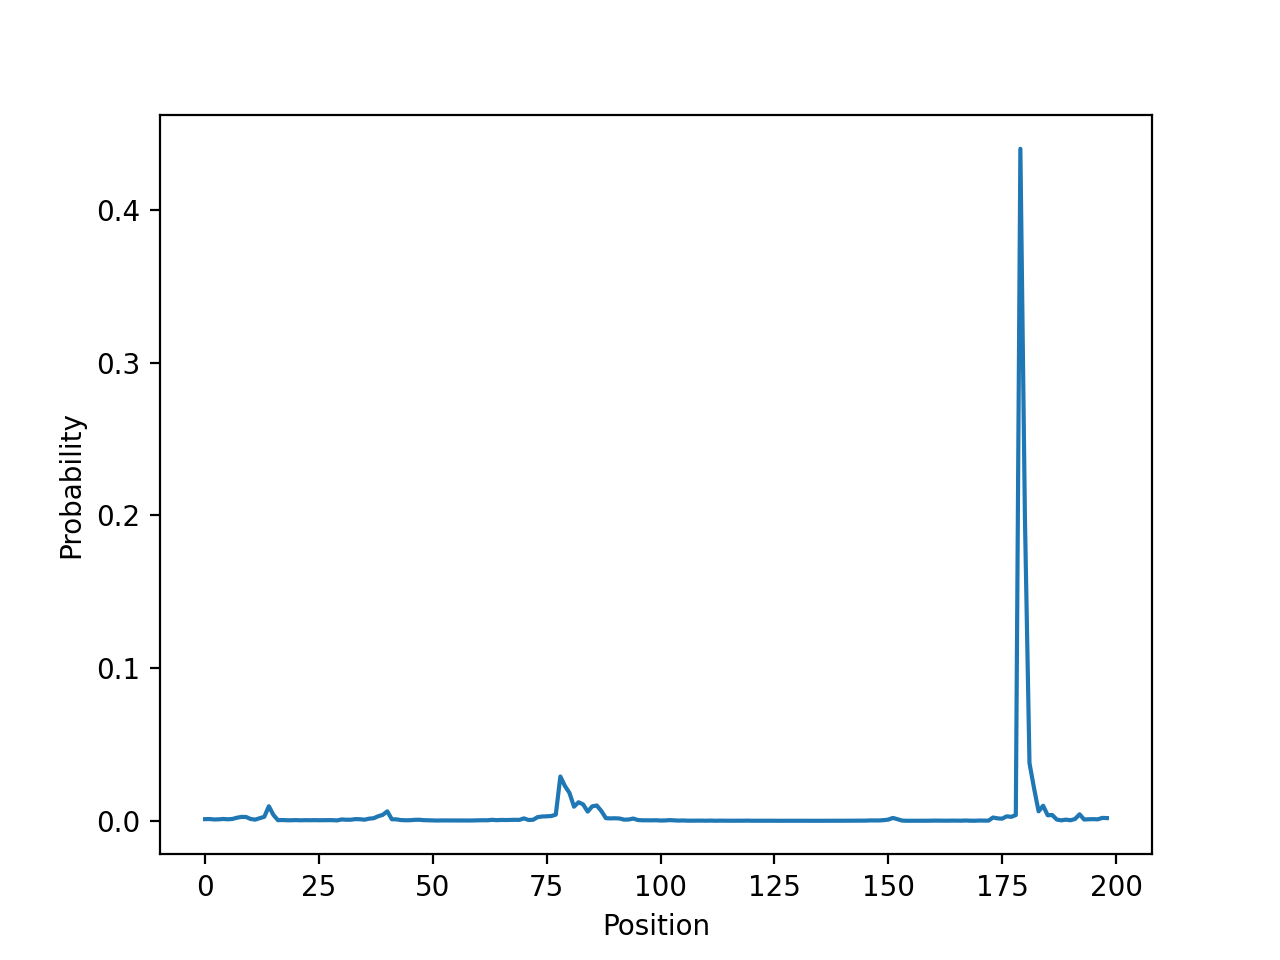

Text(0, 0.5, 'Probability')

In [7]:
fig, ax = plt.subplots()
ax.plot(cnn_output[4])
ax.set_xlabel('Position')
ax.set_ylabel('Probability')

In most cases there is a single clear peak representing the most likely position of the changepoint. We can get these predictions with np.argmax

In [8]:
positions_predicted = np.argmax(cnn_output, axis=1) + 1  # +1 to convert to original position numbering scheme
print(positions_truth.shape)

(100,)


#### Assessing the quality of predictions

<IPython.core.display.Javascript object>


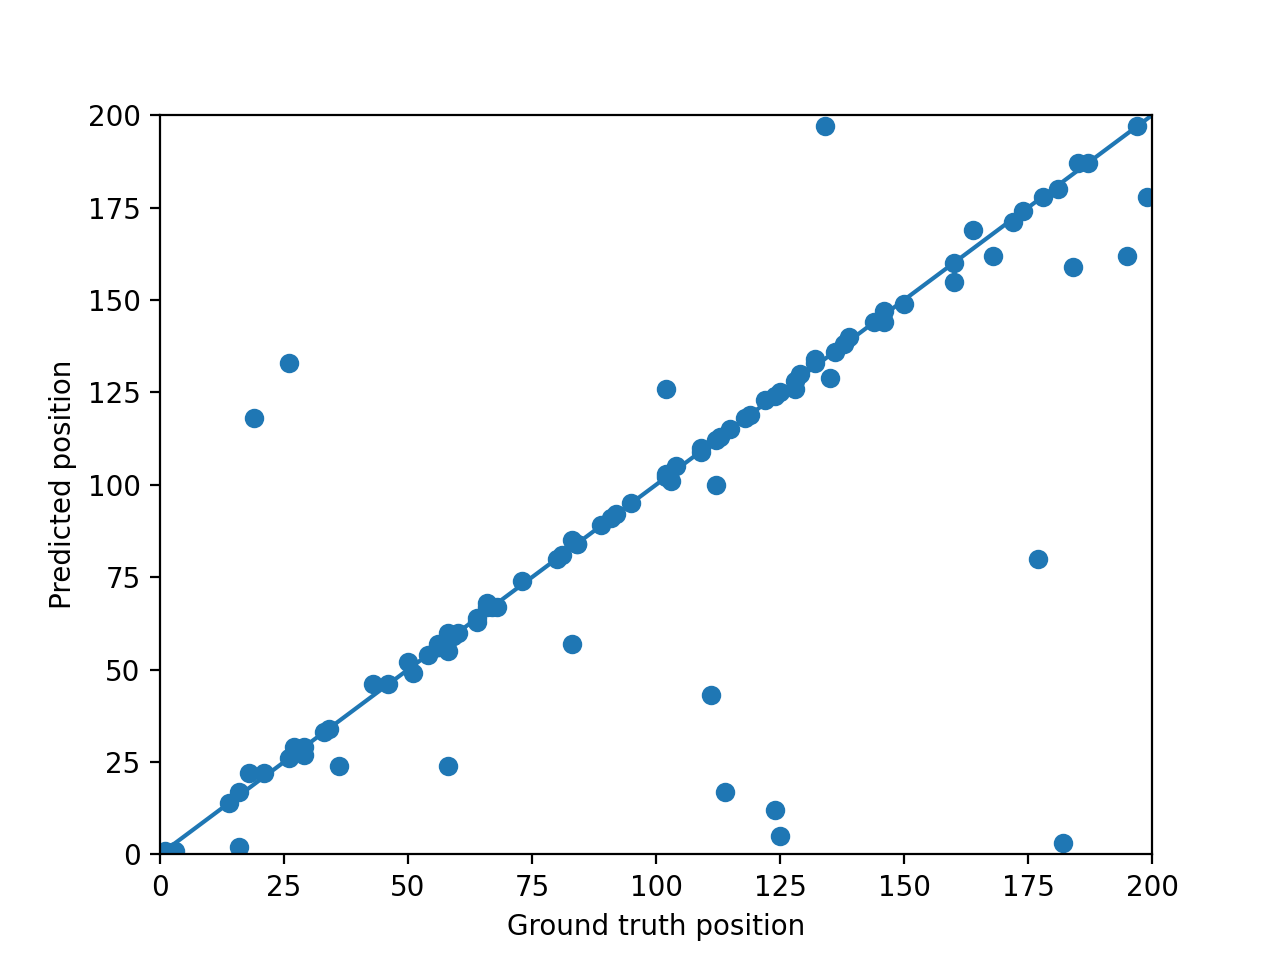

In [9]:
fig, ax = plt.subplots()
ax.scatter(positions_truth, positions_predicted)
ax.set_xlabel('Ground truth position')
ax.set_ylabel('Predicted position')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.plot([0, 200], [0, 200])

In [10]:
rmse = np.sqrt(np.mean((positions_truth - positions_predicted) ** 2))
print('Root mean squared error:', rmse)

Root mean squared error: 33.60357123878354


Most predictions fall on (or very close) to the y=x line, indicating good performance. Points that don't fall close to the y=x line often look pretty randomly distributed, suggesting that the model either has a good idea where the switch point is or it just takes a random guess. 

We can get some idea of this by excluding points for which the prediction confidence is low (peak probability below 0.1):

<IPython.core.display.Javascript object>


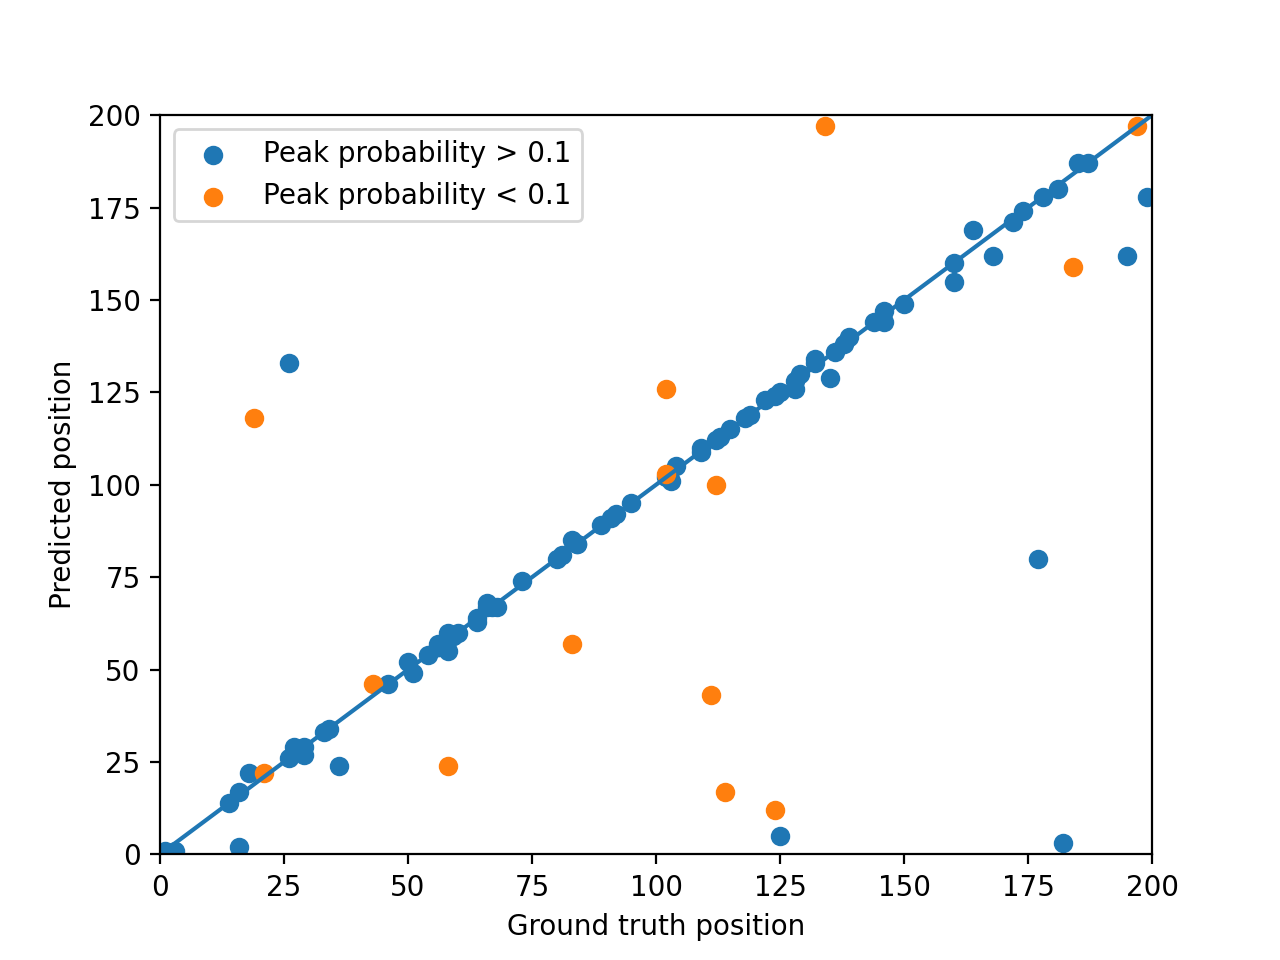

In [11]:
max_scores = np.max(cnn_output, axis=1)
threshold = 0.1

fig, ax = plt.subplots()
ax.scatter(positions_truth[max_scores > threshold], positions_predicted[max_scores > threshold], 
           label='Peak probability > 0.1')
ax.scatter(positions_truth[max_scores < threshold], positions_predicted[max_scores < threshold], 
           label='Peak probability < 0.1')
ax.set_xlabel('Ground truth position')
ax.set_ylabel('Predicted position')
ax.legend()
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.plot([0, 200], [0, 200])

Most of the erroneous predictions have a score < 0.1, whereas most of the predictions along the diagonal have a score > 0.1

For the purposes of RMSE calculation these uncertain predictions can be replaced with a 'best guess' of 100 (i.e. the middle of the trajectory):

In [12]:
rmse = np.sqrt(np.mean((positions_truth - np.where(max_scores < threshold, 100, positions_predicted)) ** 2))
print('Root mean squared error:', rmse)

Root mean squared error: 32.58143643242268
